<a href="https://colab.research.google.com/github/GeniusTang/Afann/blob/master/Sneaker_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sneaker Type Classification through transfer learning
In this project, I applied transfer learing on three deep learning models (ResNet50, VGG16, Inception_V3) to predict the type of sneakers from images in [SneakerDataset](https://drive.google.com/drive/folders/1EOROtXHeroQuaXe81oUmvjj575DnNo3c?usp=sharing) which are composed of about 1000 images crawled from Google search. All images have been separated into training and test samples. There are in total 10 different types of sneakers and around 80 training images and 20 test images for each type.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%matplotlib inline
from keras.applications import vgg16
from keras.applications import resnet50
from keras.applications import inception_v3

from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

from keras.preprocessing import image

from keras.models import Model
from keras.layers import Dense, Activation, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, SGD
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

##Number of training and test images for each sneaker type

In [0]:
import os

shoe_names = os.listdir("drive/My Drive/Sneakers/sneaker_dataset/train/")

for shoe_name in shoe_names:
    train_num = len(os.listdir(os.path.join("drive/My Drive/Sneakers/sneaker_dataset/train/", shoe_name)))
    test_num = len(os.listdir(os.path.join("drive/My Drive/Sneakers/sneaker_dataset/test/", shoe_name)))
    print('{:22s} {} training images, {} test images'.format(shoe_name, train_num, test_num))

Air_Max_90             79 training images, 19 test images
Air_Max_95             77 training images, 20 test images
Air_Jordan_4           77 training images, 18 test images
Air_Max_1              79 training images, 20 test images
Air_Jordan_1           79 training images, 17 test images
Air_Force_1            80 training images, 20 test images
Adidas_Ultra_Boost_4   73 training images, 18 test images
Adidas_NMD_R1          80 training images, 20 test images
Yeezy_350              80 training images, 20 test images
Yeezy_500              76 training images, 20 test images


##Load different models (ResNet50, VGG16, InceptionV3) with weights that have been trained on ImageNet and then test their accuracy on our samples. The correct label should be 'running shoe'.

In [0]:
def predict_imgs(dir_path, num, model_name):  
    shoe_names = os.listdir(dir_path)
    fig, ax = plt.subplots(len(shoe_names), num, figsize=(12, 25))
    plt.tight_layout()
    
    if model_name == 'ResNet50':
        model = ResNet50(weights='imagenet')
        preprocess_input = resnet50.preprocess_input
        decode_predictions = resnet50.decode_predictions
        target_size=(224, 224)
        
    elif model_name == 'VGG16':
        model = VGG16(weights='imagenet')
        preprocess_input = vgg16.preprocess_input
        decode_predictions = vgg16.decode_predictions
        target_size=(224, 224)
        
    elif model_name == 'InceptionV3':
        model = InceptionV3(weights='imagenet')
        preprocess_input = inception_v3.preprocess_input
        decode_predictions = inception_v3.decode_predictions
        target_size=(299, 299)
    
    count = 0
    for i in range(len(shoe_names)):
        shoe_name = shoe_names[i]
        shoe_name_dir = os.path.join(dir_path, shoe_name)
        imgs = [os.path.join(shoe_name_dir, img_name) for img_name in os.listdir(shoe_name_dir)[:num]]
        for j in range(num):
            x = image.img_to_array(image.load_img(imgs[j], target_size=target_size))
            ax[i, j].imshow(x/255)
            ax[i, j].set_title(os.path.basename(imgs[j]))
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            x = np.expand_dims(x, axis=0)
        
            x = preprocess_input(x)
            pred = model.predict(x)
             
            idx, category, prob = decode_predictions(pred, top=1)[0][0]
            if 'shoe' in category:
                color = 'black'
            else:
                count += 1
                color = 'red'
            ax[i, j].text(0.2, -0.08, '{}: {:.3f}'.format(category, prob), color=color, transform=ax[i, j].transAxes)
    print('Accuracy of {}: {:.3f}\n'.format(model_name, 1-count/(10*num)))

## ResNet50

Accuracy of ResNet50: 0.740



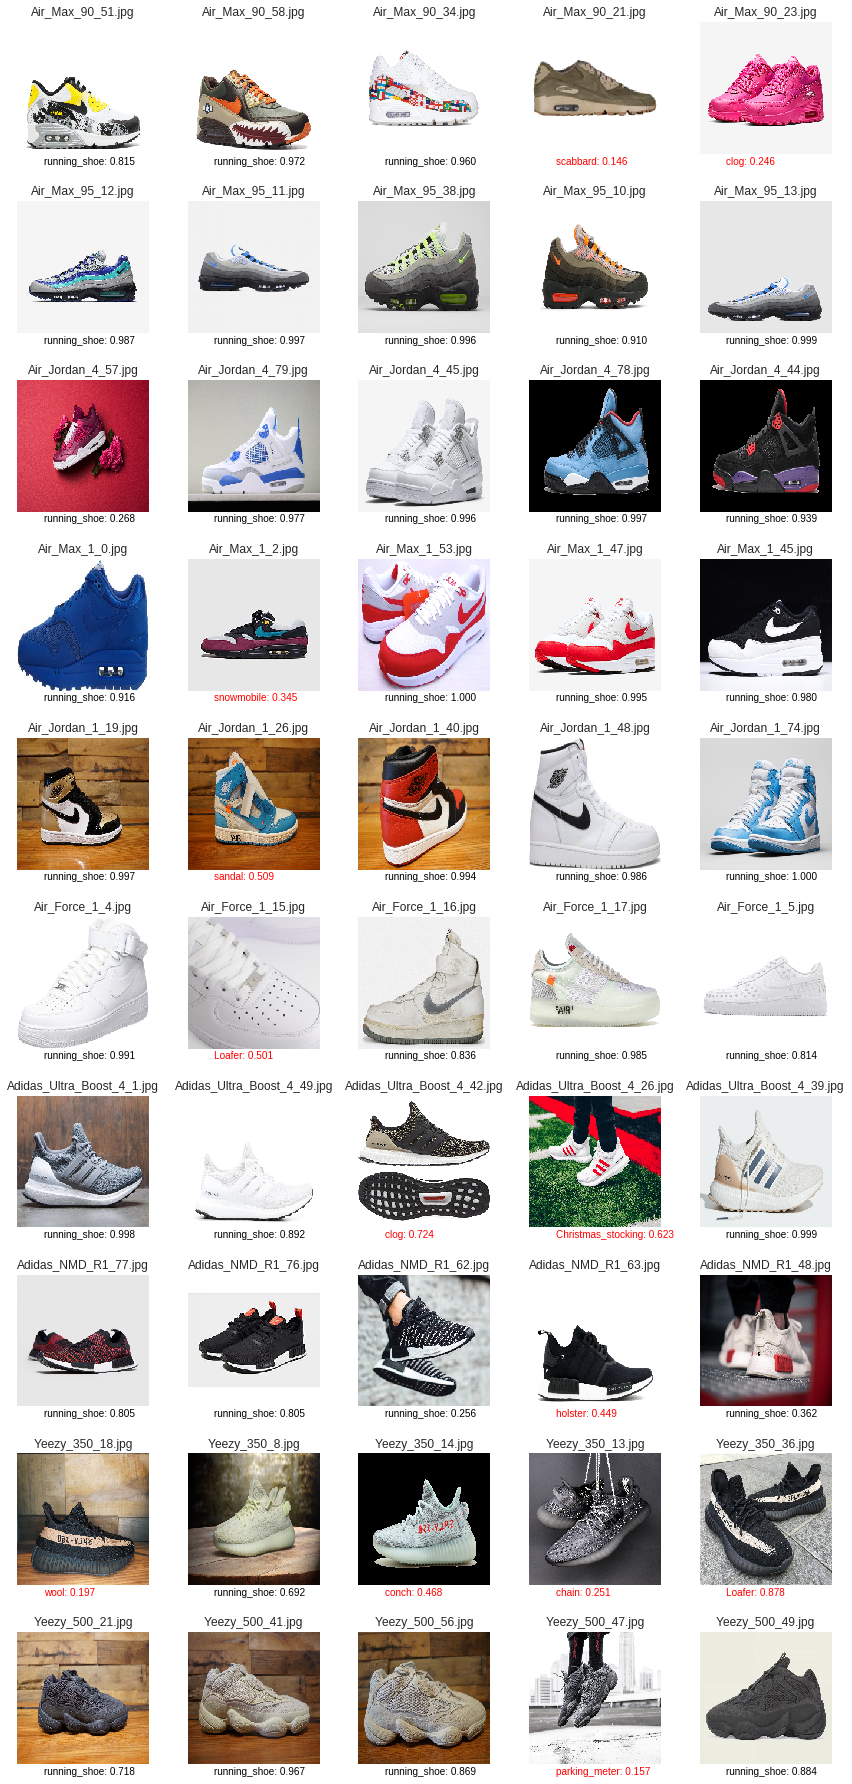

In [0]:
predict_imgs("drive/My Drive/Sneakers/sneaker_dataset/train/", 5, 'ResNet50')

## VGG16

Accuracy of VGG16: 0.760



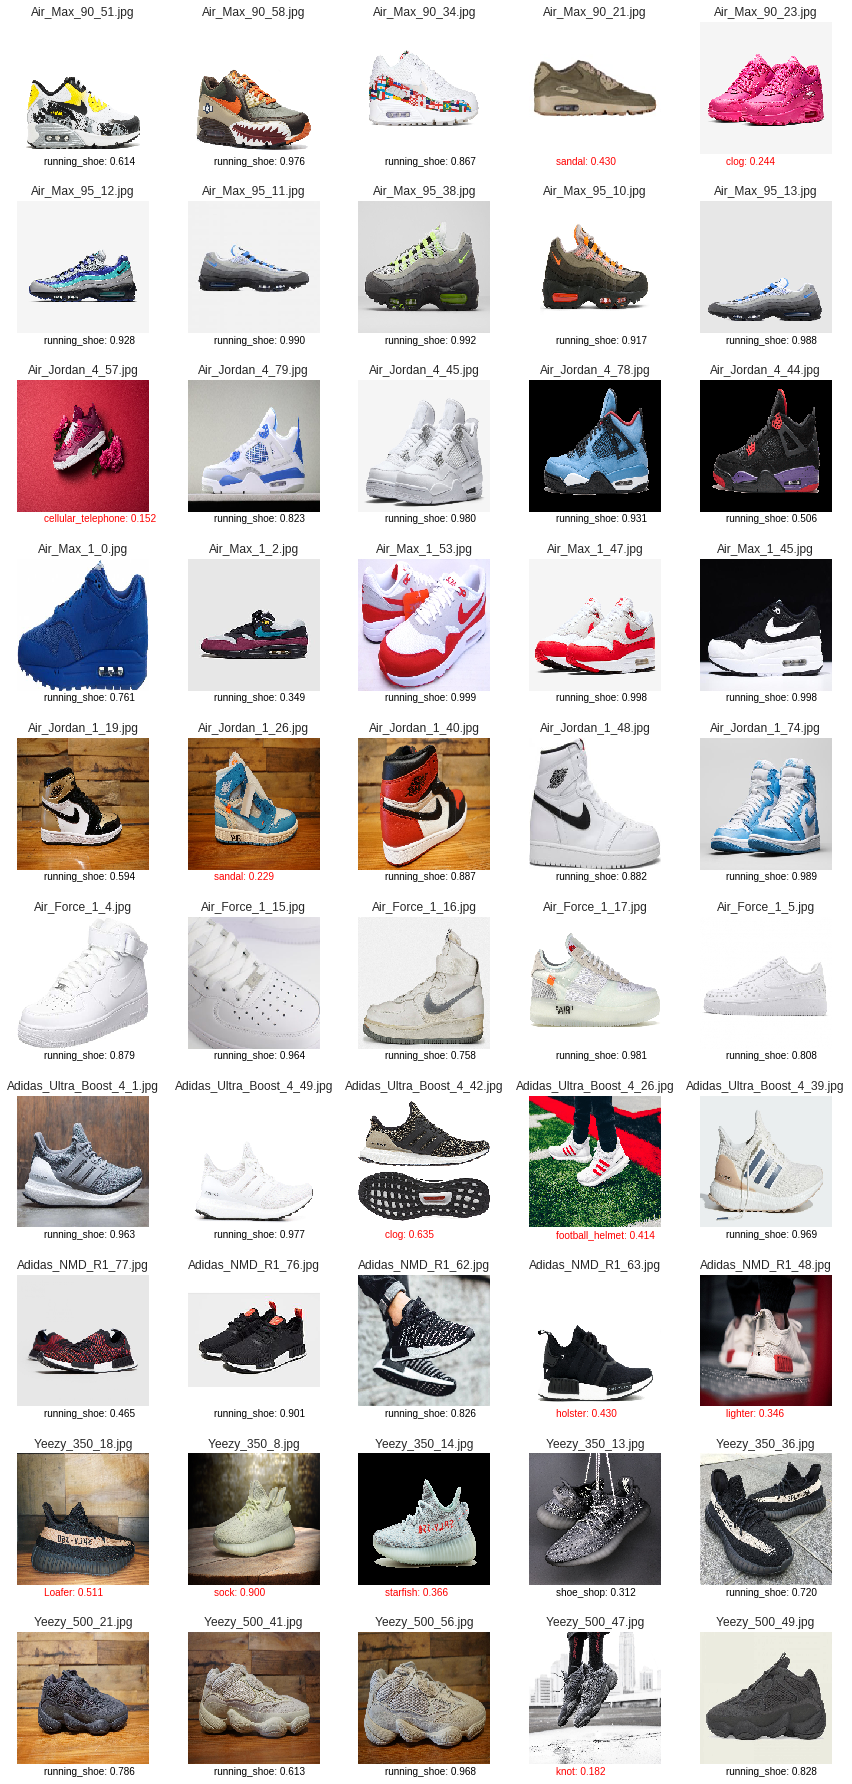

In [0]:
predict_imgs("drive/My Drive/Sneakers/sneaker_dataset/train/", 5, 'VGG16')

## InceptionV3

Accuracy of InceptionV3: 0.880



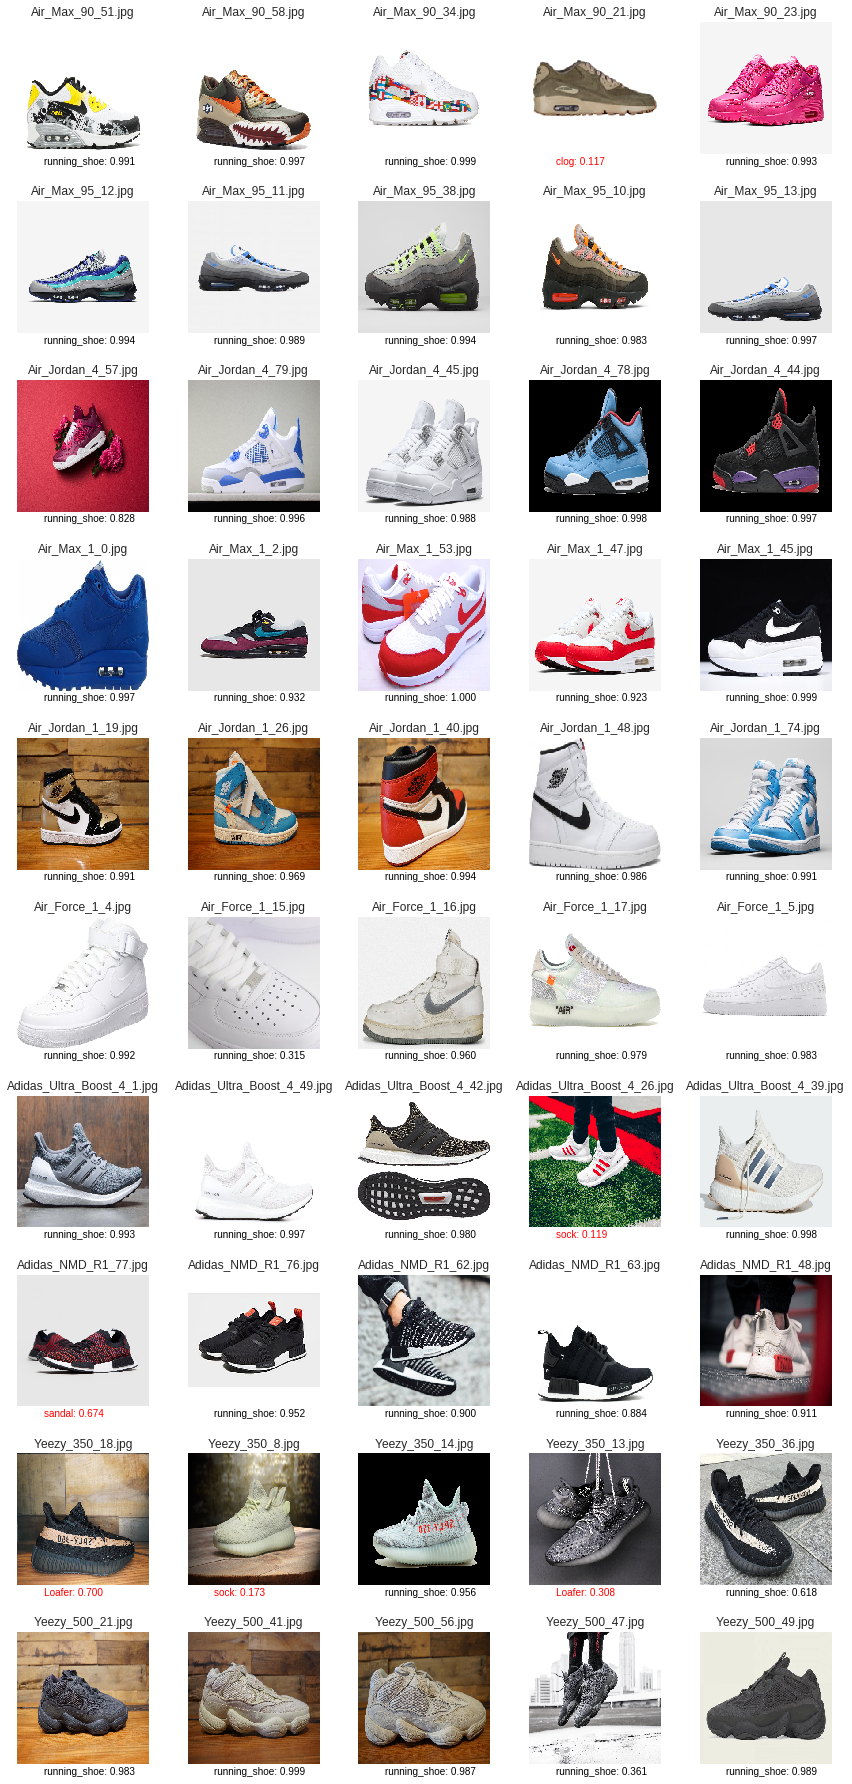

In [0]:
predict_imgs("drive/My Drive/Sneakers/sneaker_dataset/train/", 5, 'InceptionV3')

### Summary
- Inception_V3 gave the highest accuracy of 0.88 among all three models.
- Most of misclassified labels are other kind of shoes such as sandal, loafer and clog.
- Yeezy 350 are actually sock shoes, so it's not surprising that some models predicted them as socks.

## Load pretrained models without top layer, feeze all base layers and add one average pooling layer, one fully connected layer with ReLU activation and one 10-way softmax layer as output.

In [0]:
def init_model(model_name, dense):
    if model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False)
    
    elif model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False)     
        
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False)     
        
    x = base_model.output
    # Add an Average Pooling layer
    x = GlobalAveragePooling2D()(x)
    # BatchNormalization
    x = BatchNormalization()(x)
    # Add a fully-connected layer
    x = Dense(dense)(x)
    # BatchNormalization
    x = BatchNormalization()(x)
    # ReLU activation
    x = Activation('relu')(x)
    # Add a softmax layer 
    predictions = Dense(10, activation='softmax')(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # Train only the top layers
    # Freeze all base layers
    for layer in base_model.layers:
        layer.trainable = False
        
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    adam = Adam()
    
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])
    return model

## Fine tune top layers of different models

In [0]:
def fine_tune_model(model, model_name, dense):
    if model_name == 'ResNet50':
        preprocess_input = resnet50.preprocess_input
        target_size=(224, 224)
    elif model_name == 'VGG16':
        preprocess_input = vgg16.preprocess_input
        target_size=(224, 224)
    elif model_name == 'InceptionV3':
        preprocess_input = inception_v3.preprocess_input
        target_size=(299, 299)
        
    train_gen = image.ImageDataGenerator(horizontal_flip=True, \
                                         rotation_range=45, \
                                         preprocessing_function=preprocess_input)

    train_generator = train_gen.flow_from_directory("drive/My Drive/Sneakers/sneaker_dataset/train/", \
                                                    target_size=target_size, \
                                                    batch_size=32, \
                                                    class_mode="categorical")

    validation_gen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
    validation_generator = validation_gen.flow_from_directory("drive/My Drive/Sneakers/sneaker_dataset/test/",\
                                                              target_size=target_size, \
                                                              batch_size=32, \
                                                              class_mode="categorical")
    
    #Early stop if validation accuracy no longer increase after 5 epochs
    early_stop = EarlyStopping(monitor='val_acc', patience=5)
    
    #Save best model
    check_point = ModelCheckpoint("drive/My Drive/Sneakers/fine_tuned_{}_{}.h5".format(model_name, dense),\
                                  save_best_only=True, verbose=1, monitor='val_acc')
    
    steps_per_epoch = train_generator.samples / 32
    validation_steps= validation_generator.samples / 32
    
    history = model.fit_generator(train_generator, \
                                  steps_per_epoch=steps_per_epoch,\
                                  epochs=30, \
                                  validation_data=validation_generator,\
                                  validation_steps=validation_steps,\
                                  callbacks = [early_stop, check_point])
    return history

In [0]:
def learning_curve(history):
    val_acc = history['val_acc']
    acc = history['acc']
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot(acc, label='Training Accuracy')
    plt.legend(loc='center right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

## Fine tune ResNet50 (Dense layer size = 64, 128, 256)

In [0]:
resnet_model = init_model('ResNet50', 64)
resnet_64_history = fine_tune_model(resnet_model, 'ResNet50', 64)

Found 780 images belonging to 10 classes.
Found 192 images belonging to 10 classes.
Epoch 1/30
25/24 [==============================] - 85s 3s/step - loss: 1.7281 - acc: 0.4412 - val_loss: 1.4117 - val_acc: 0.4740

Epoch 00001: val_acc improved from -inf to 0.47396, saving model to drive/My Drive/Sneakers/fine_tuned_ResNet50_64.h5
Epoch 2/30
25/24 [==============================] - 18s 738ms/step - loss: 0.8973 - acc: 0.7883 - val_loss: 1.2133 - val_acc: 0.5156

Epoch 00002: val_acc improved from 0.47396 to 0.51562, saving model to drive/My Drive/Sneakers/fine_tuned_ResNet50_64.h5
Epoch 3/30
25/24 [==============================] - 32s 1s/step - loss: 0.6710 - acc: 0.8584 - val_loss: 1.0651 - val_acc: 0.6094

Epoch 00003: val_acc improved from 0.51562 to 0.60938, saving model to drive/My Drive/Sneakers/fine_tuned_ResNet50_64.h5
Epoch 4/30
25/24 [==============================] - 32s 1s/step - loss: 0.5399 - acc: 0.8844 - val_loss: 1.0123 - val_acc: 0.6302

Epoch 00004: val_acc improved

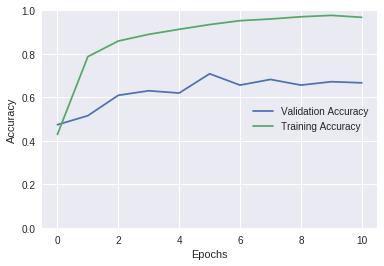

In [0]:
learning_curve(resnet_64_history.history)

In [0]:
resnet_model = init_model('ResNet50', 128)
resnet_128_history = fine_tune_model(resnet_model, 'ResNet50', 128)

Found 780 images belonging to 10 classes.
Found 192 images belonging to 10 classes.
Epoch 1/30
25/24 [==============================] - 80s 3s/step - loss: 1.5175 - acc: 0.4840 - val_loss: 1.1056 - val_acc: 0.6250

Epoch 00001: val_acc improved from -inf to 0.62500, saving model to drive/My Drive/Sneakers/fine_tuned_ResNet50_128.h5
Epoch 2/30
25/24 [==============================] - 19s 759ms/step - loss: 0.6450 - acc: 0.8336 - val_loss: 1.0251 - val_acc: 0.6354

Epoch 00002: val_acc improved from 0.62500 to 0.63542, saving model to drive/My Drive/Sneakers/fine_tuned_ResNet50_128.h5
Epoch 3/30
25/24 [==============================] - 32s 1s/step - loss: 0.4486 - acc: 0.8859 - val_loss: 1.0280 - val_acc: 0.6094

Epoch 00003: val_acc did not improve from 0.63542
Epoch 4/30
25/24 [==============================] - 32s 1s/step - loss: 0.3524 - acc: 0.9359 - val_loss: 1.1457 - val_acc: 0.5833

Epoch 00004: val_acc did not improve from 0.63542
Epoch 5/30
25/24 [==============================

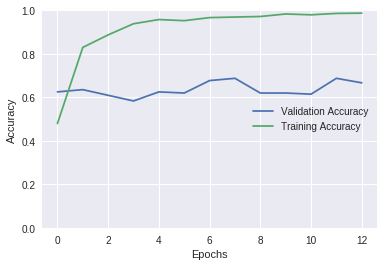

In [0]:
learning_curve(resnet_128_history.history)

In [0]:
resnet_model = init_model('ResNet50', 256)
resnet_256_history = fine_tune_model(resnet_model, 'ResNet50', 256)

Found 780 images belonging to 10 classes.
Found 192 images belonging to 10 classes.
Epoch 1/30
25/24 [==============================] - 76s 3s/step - loss: 1.3645 - acc: 0.5408 - val_loss: 1.1508 - val_acc: 0.5990

Epoch 00001: val_acc improved from -inf to 0.59896, saving model to drive/My Drive/Sneakers/fine_tuned_ResNet50_256.h5
Epoch 2/30
25/24 [==============================] - 19s 755ms/step - loss: 0.5076 - acc: 0.8496 - val_loss: 0.9945 - val_acc: 0.6458

Epoch 00002: val_acc improved from 0.59896 to 0.64583, saving model to drive/My Drive/Sneakers/fine_tuned_ResNet50_256.h5
Epoch 3/30
25/24 [==============================] - 31s 1s/step - loss: 0.3680 - acc: 0.9029 - val_loss: 0.9348 - val_acc: 0.6771

Epoch 00003: val_acc improved from 0.64583 to 0.67708, saving model to drive/My Drive/Sneakers/fine_tuned_ResNet50_256.h5
Epoch 4/30
25/24 [==============================] - 32s 1s/step - loss: 0.2524 - acc: 0.9467 - val_loss: 0.9118 - val_acc: 0.6458

Epoch 00004: val_acc did n

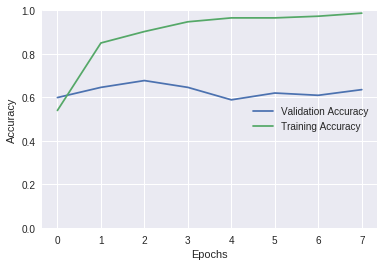

In [0]:
learning_curve(resnet_256_history.history)

## Fine tune VGG16 (Dense layer size = 64, 128, 256)

In [0]:
vgg16_model = init_model('VGG16', 64)
vgg16_64_history = fine_tune_model(resnet_model, 'VGG16', 64)

Found 780 images belonging to 10 classes.
Found 192 images belonging to 10 classes.
Epoch 1/30
25/24 [==============================] - 77s 3s/step - loss: 0.0459 - acc: 0.9962 - val_loss: 0.8846 - val_acc: 0.7344

Epoch 00001: val_acc improved from -inf to 0.73438, saving model to drive/My Drive/Sneakers/fine_tuned_VGG16_64.h5
Epoch 2/30
25/24 [==============================] - 32s 1s/step - loss: 0.0364 - acc: 0.9975 - val_loss: 0.8938 - val_acc: 0.7344

Epoch 00002: val_acc did not improve from 0.73438
Epoch 3/30
25/24 [==============================] - 33s 1s/step - loss: 0.0411 - acc: 0.9962 - val_loss: 0.9328 - val_acc: 0.7188

Epoch 00003: val_acc did not improve from 0.73438
Epoch 4/30
25/24 [==============================] - 32s 1s/step - loss: 0.0465 - acc: 0.9912 - val_loss: 0.8586 - val_acc: 0.7031

Epoch 00004: val_acc did not improve from 0.73438
Epoch 5/30
25/24 [==============================] - 32s 1s/step - loss: 0.0307 - acc: 0.9975 - val_loss: 0.9105 - val_acc: 0.70

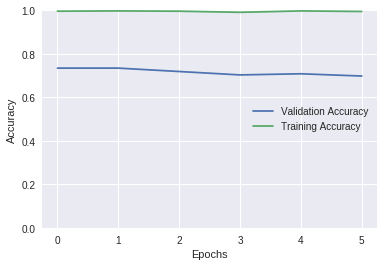

In [0]:
learning_curve(vgg16_64_history.history)

In [0]:
vgg16_model = init_model('VGG16', 128)
vgg16_128_history = fine_tune_model(resnet_model, 'VGG16', 128)

Found 780 images belonging to 10 classes.
Found 192 images belonging to 10 classes.
Epoch 1/30
25/24 [==============================] - 77s 3s/step - loss: 0.0712 - acc: 0.9937 - val_loss: 1.0110 - val_acc: 0.6927

Epoch 00001: val_acc improved from -inf to 0.69271, saving model to drive/My Drive/Sneakers/fine_tuned_VGG16_128.h5
Epoch 2/30
25/24 [==============================] - 31s 1s/step - loss: 0.0737 - acc: 0.9892 - val_loss: 0.9665 - val_acc: 0.6927

Epoch 00002: val_acc did not improve from 0.69271
Epoch 3/30
25/24 [==============================] - 32s 1s/step - loss: 0.0634 - acc: 0.9900 - val_loss: 1.0750 - val_acc: 0.6823

Epoch 00003: val_acc did not improve from 0.69271
Epoch 4/30
25/24 [==============================] - 32s 1s/step - loss: 0.0598 - acc: 0.9937 - val_loss: 1.1448 - val_acc: 0.6458

Epoch 00004: val_acc did not improve from 0.69271
Epoch 5/30
25/24 [==============================] - 33s 1s/step - loss: 0.0490 - acc: 0.9892 - val_loss: 1.1234 - val_acc: 0.6

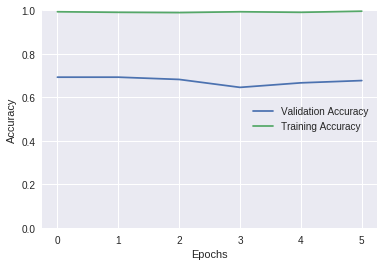

In [0]:
learning_curve(vgg16_128_history.history)

In [0]:
vgg16_model = init_model('VGG16', 256)
vgg16_256_history = fine_tune_model(resnet_model, 'VGG16', 256)

58892288/58889256 [==============================] - 1s 0us/step
Found 780 images belonging to 10 classes.
Found 192 images belonging to 10 classes.
Epoch 1/30
25/24 [==============================] - 77s 3s/step - loss: 0.1577 - acc: 0.9800 - val_loss: 0.8309 - val_acc: 0.6823

Epoch 00001: val_acc improved from -inf to 0.68229, saving model to drive/My Drive/Sneakers/fine_tuned_VGG16_256.h5
Epoch 2/30
25/24 [==============================] - 32s 1s/step - loss: 0.1728 - acc: 0.9690 - val_loss: 0.9128 - val_acc: 0.6823

Epoch 00002: val_acc did not improve from 0.68229
Epoch 3/30
25/24 [==============================] - 32s 1s/step - loss: 0.1184 - acc: 0.9850 - val_loss: 0.9006 - val_acc: 0.6719

Epoch 00003: val_acc did not improve from 0.68229
Epoch 4/30
25/24 [==============================] - 32s 1s/step - loss: 0.1226 - acc: 0.9792 - val_loss: 0.8259 - val_acc: 0.6927

Epoch 00004: val_acc improved from 0.68229 to 0.69271, saving model to drive/My Drive/Sneakers/fine_tuned_VGG16

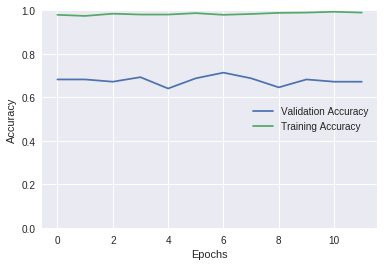

In [0]:
learning_curve(vgg16_256_history.history)

## Fine tune InceptionV3 (Dense layer size = 64, 128)

In [0]:
inception_model = init_model('InceptionV3', 64)
inception_64_history = fine_tune_model(resnet_model, 'InceptionV3', 64)

87916544/87910968 [==============================] - 1s 0us/step
Found 780 images belonging to 10 classes.
Found 192 images belonging to 10 classes.
Epoch 1/30
25/24 [==============================] - 94s 4s/step - loss: 0.2557 - acc: 0.9167 - val_loss: 5.5752 - val_acc: 0.0625

Epoch 00001: val_acc improved from -inf to 0.06250, saving model to drive/My Drive/Sneakers/fine_tuned_InceptionV3_64.h5
Epoch 2/30
25/24 [==============================] - 39s 2s/step - loss: 0.1643 - acc: 0.9459 - val_loss: 5.7620 - val_acc: 0.1094

Epoch 00002: val_acc improved from 0.06250 to 0.10938, saving model to drive/My Drive/Sneakers/fine_tuned_InceptionV3_64.h5
Epoch 3/30
25/24 [==============================] - 41s 2s/step - loss: 0.1493 - acc: 0.9585 - val_loss: 7.9977 - val_acc: 0.0938

Epoch 00003: val_acc did not improve from 0.10938
Epoch 4/30
25/24 [==============================] - 42s 2s/step - loss: 0.0954 - acc: 0.9800 - val_loss: 6.8385 - val_acc: 0.0938

Epoch 00004: val_acc did not imp

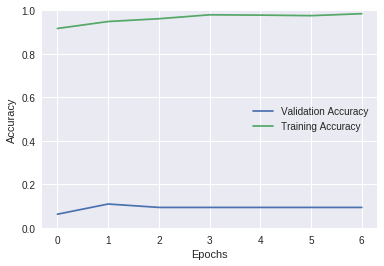

In [0]:
learning_curve(inception_64_history.history)

In [0]:
inception_model = init_model('InceptionV3', 128)
inception_128_history = fine_tune_model(resnet_model, 'InceptionV3', 128)

Found 780 images belonging to 10 classes.
Found 192 images belonging to 10 classes.
Epoch 1/30
25/24 [==============================] - 98s 4s/step - loss: 0.0611 - acc: 0.9812 - val_loss: 8.1697 - val_acc: 0.0938

Epoch 00001: val_acc improved from -inf to 0.09375, saving model to drive/My Drive/Sneakers/fine_tuned_InceptionV3_128.h5
Epoch 2/30
25/24 [==============================] - 40s 2s/step - loss: 0.0511 - acc: 0.9887 - val_loss: 7.1976 - val_acc: 0.0938

Epoch 00002: val_acc did not improve from 0.09375
Epoch 3/30
25/24 [==============================] - 41s 2s/step - loss: 0.0383 - acc: 0.9975 - val_loss: 6.8501 - val_acc: 0.0938

Epoch 00003: val_acc did not improve from 0.09375
Epoch 4/30
25/24 [==============================] - 41s 2s/step - loss: 0.0337 - acc: 0.9950 - val_loss: 7.1880 - val_acc: 0.0938

Epoch 00004: val_acc did not improve from 0.09375
Epoch 5/30
25/24 [==============================] - 42s 2s/step - loss: 0.0332 - acc: 0.9950 - val_loss: 7.4693 - val_ac

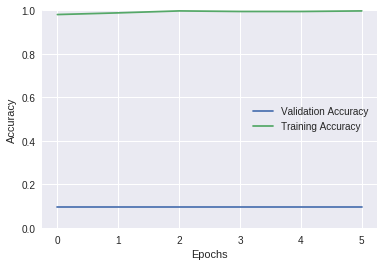

In [0]:
learning_curve(inception_128_history.history)

### Summary
- Fine tuned VGG16 with 64 nodes in dense layer has the highest accuracy 0.73.
- All fine tuned models can achieve close to 1 training accuracy, there's an overfitting problem.
- InceptionV3 has very low validation accuracy 0.09, it's just random guessing.

## Load the best fine tuned model

In [0]:
from keras.models import load_model

best_model = load_model("drive/My Drive/Sneakers/fine_tuned_VGG16_64.h5")

In [0]:
def decode_predictions(pred, top=1):
    labels = sorted(os.listdir("drive/My Drive/Sneakers/sneaker_dataset/test/")) 
    ans = []
    for i in range(len(pred)):
        orders = (-pred[i]).argsort()
        ans.append([(orders[i], labels[orders[i]], pred[0][orders[i]]) for i in range(top)])
    return ans

In [0]:
def find_tuned_predict_imgs(dir_path, num, model, model_name):  
    shoe_names = os.listdir(dir_path)
    fig, ax = plt.subplots(len(shoe_names), num, figsize=(20, 20))
    plt.tight_layout()
    
    if model_name == 'ResNet50':
        preprocess_input = resnet50.preprocess_input
        target_size=(224, 224)
        
    elif model_name == 'VGG16':
        preprocess_input = vgg16.preprocess_input
        target_size=(224, 224)
        
    elif model_name == 'InceptionV3':
        preprocess_input = inception_v3.preprocess_input
        target_size=(299, 299)
    
    count = 0
    for i in range(len(shoe_names)):
        shoe_name = shoe_names[i]
        shoe_name_dir = os.path.join(dir_path, shoe_name)
        imgs = [os.path.join(shoe_name_dir, img_name) for img_name in os.listdir(shoe_name_dir)[:num]]
        for j in range(num):
            x = image.img_to_array(image.load_img(imgs[j], target_size=target_size))
            ax[i, j].imshow(x/255)
            ax[i, j].set_title(os.path.basename(imgs[j]).strip('.jpg'))
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            x = np.expand_dims(x, axis=0)
        
            x = preprocess_input(x)
            pred = model.predict(x)
            
            labels = decode_predictions(pred, top=2)[0]
            idx_1, category_1, prob_1 = labels[0]
            idx_2, category_2, prob_2 = labels[1]
            
            if category_1 == shoe_name:
                color = 'black'
            else:
                count += 1
                color = 'red'
            ax[i, j].text(0, -0.08, '{}: {:.3f}'.format(category_1, prob_1), color=color, transform=ax[i, j].transAxes)
            ax[i, j].text(0, -0.18, '{}: {:.3f}'.format(category_2, prob_2), color=color, transform=ax[i, j].transAxes)
    plt.savefig("drive/My Drive/Sneakers/predication.png", format='png', bbox_inches='tight')
    print('Accuracy of {}: {:.3f}\n'.format(model_name, 1-count/(10*num)))

## Look at its top-2 predictions for each type of shoe

Accuracy of VGG16: 0.740



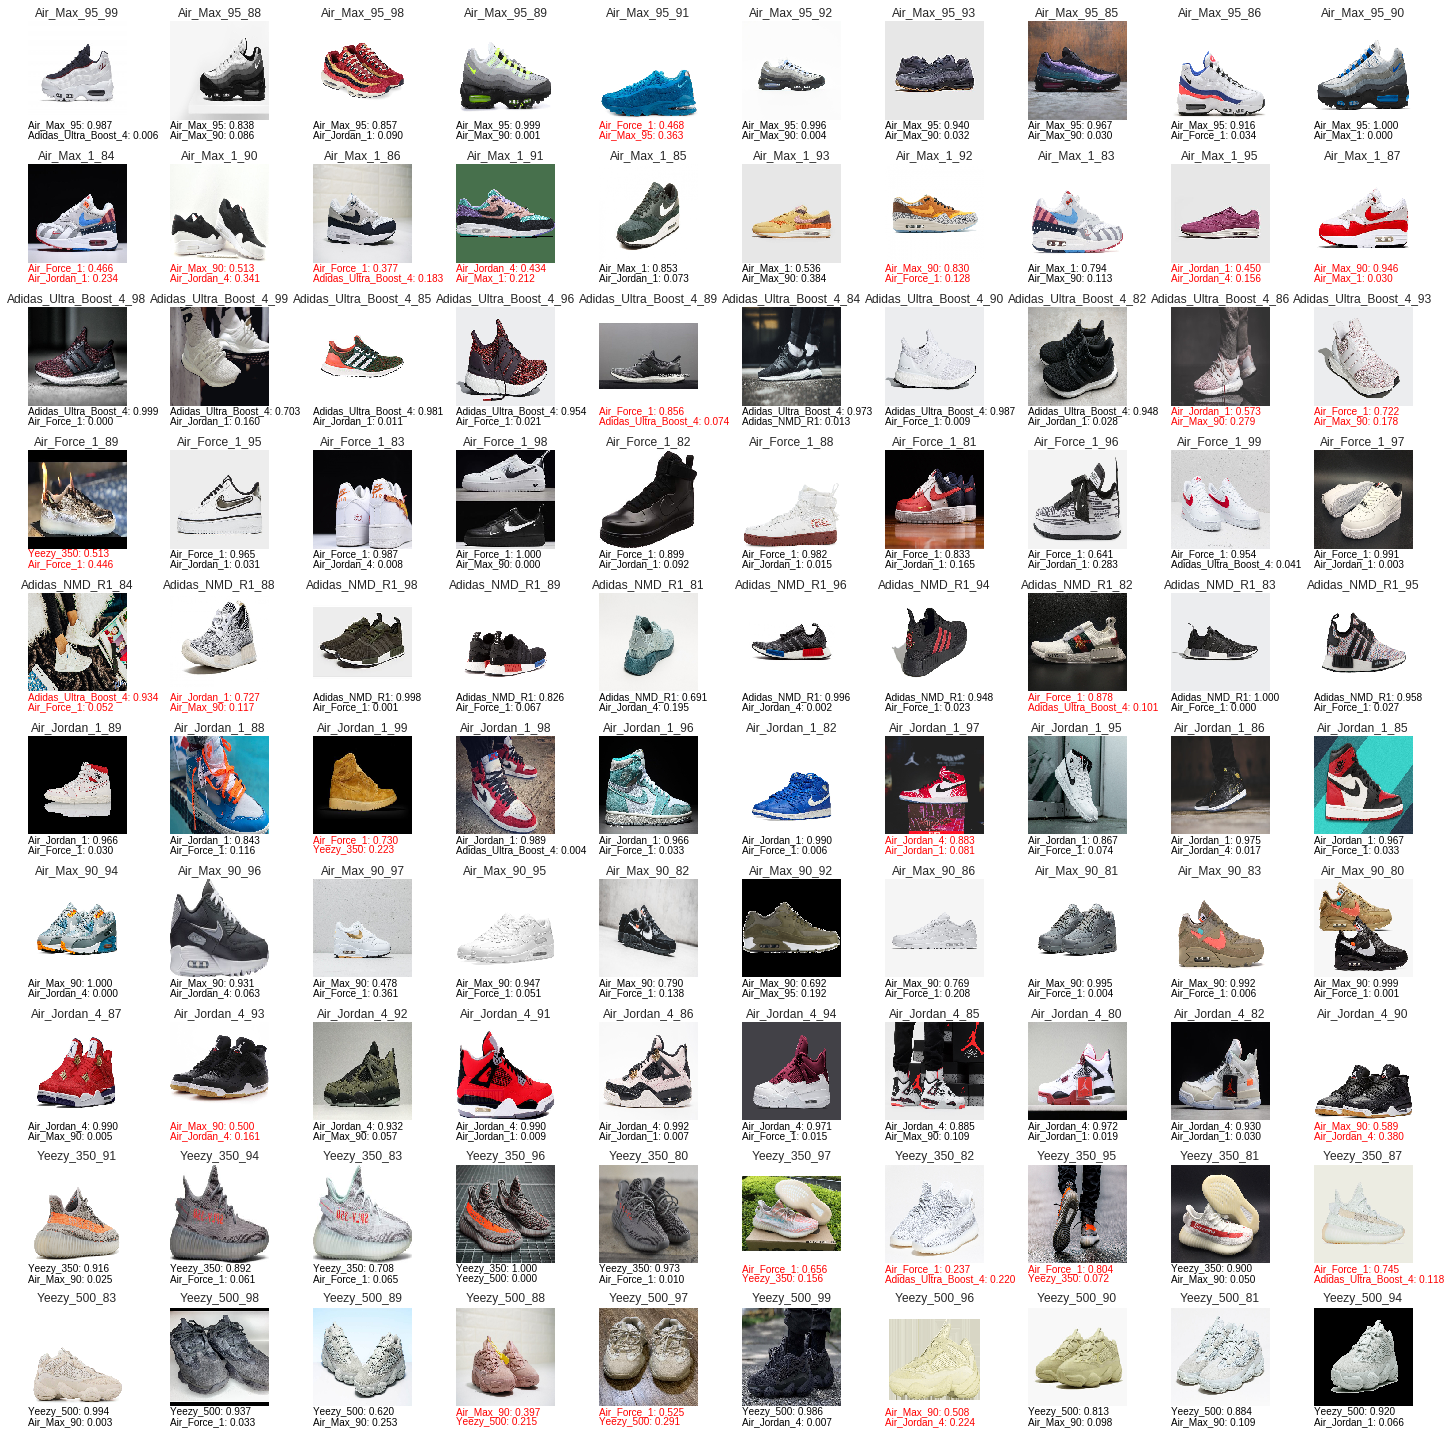

In [0]:
find_tuned_predict_imgs("drive/My Drive/Sneakers/sneaker_dataset/test/", 10, best_model, 'VGG16')

In [0]:
test_gen = image.ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)
test_generator = test_gen.flow_from_directory("drive/My Drive/Sneakers/sneaker_dataset/test/",\
                                              target_size=(224, 224), \
                                              batch_size=1, \
                                              shuffle=False, \
                                              class_mode="categorical")

pred = best_model.predict_generator(test_generator, steps=len(test_generator))

Found 192 images belonging to 10 classes.


## Top-K accuracy

In [0]:
def top_k_accuracy(true_labels, pred, k):
    total = len(true_labels)
    correct = 0
    for i in range(total):
        if true_labels[i] in (-pred[i]).argsort()[:k]:
            correct += 1
    return correct / total

In [0]:
for i in range(1, 6):
    acc = top_k_accuracy(test_generator.classes, pred, i)
    print('Top {} accuracy: {:.3f}'.format(i, acc))

Top 1 accuracy: 0.734
Top 2 accuracy: 0.839
Top 3 accuracy: 0.906
Top 4 accuracy: 0.927
Top 5 accuracy: 0.953


## Classification report for each type of shoe

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

labels = sorted(os.listdir("drive/My Drive/Sneakers/sneaker_dataset/test/"))

label_dict = dict(enumerate(labels))

true_labels = [label_dict[i] for i in test_generator.classes]

predicted_labels = [label_dict[i] for i in np.argmax(pred, axis=1)]
print(classification_report(true_labels, predicted_labels))

                      precision    recall  f1-score   support

       Adidas_NMD_R1       1.00      0.70      0.82        20
Adidas_Ultra_Boost_4       0.71      0.67      0.69        18
         Air_Force_1       0.47      0.95      0.63        20
        Air_Jordan_1       0.71      0.88      0.79        17
        Air_Jordan_4       0.80      0.89      0.84        18
           Air_Max_1       0.83      0.25      0.38        20
          Air_Max_90       0.61      0.89      0.72        19
          Air_Max_95       0.95      0.90      0.92        20
           Yeezy_350       0.85      0.55      0.67        20
           Yeezy_500       1.00      0.70      0.82        20

           micro avg       0.73      0.73      0.73       192
           macro avg       0.79      0.74      0.73       192
        weighted avg       0.80      0.73      0.73       192



## Confusion Matrix

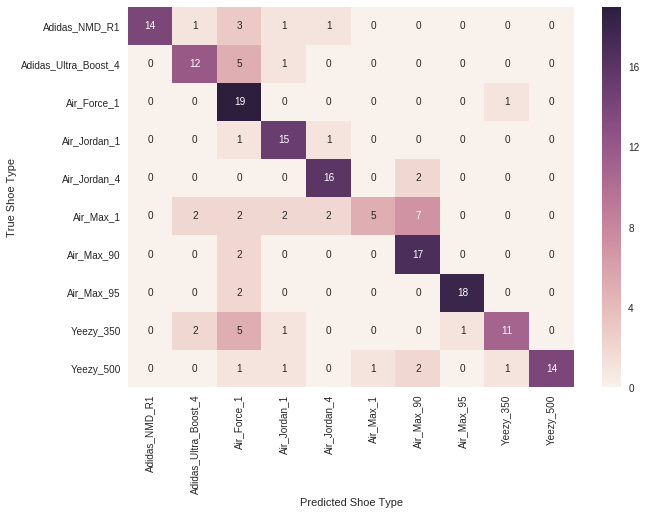

In [0]:
import seaborn as sns
import pandas as pd


cm = confusion_matrix(true_labels, predicted_labels)
df_cm = pd.DataFrame(cm, index = labels, columns = labels)
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True);
ax.set_xlabel('Predicted Shoe Type');
ax.set_ylabel('True Shoe Type');
plt.savefig("drive/My Drive/Sneakers/confusion.png", format='png', bbox_inches='tight')

## Summary
- Air Max 1 is very likely to be predicted as Air Max 90. To be honest, I don't even know the differences between [Air Max 1](https://stockx.imgix.net/Nike-Air-Max-1-Have-a-Nike-Day-Product.jpg?fit=fill&bg=FFFFFF&w=358&h=255&auto=format,compress&trim=color&q=90&dpr=2&updated_at=1550692207) and [Air Max 90](https://stockx.imgix.net/Nike-Air-Max-90-1-Sport-Red-Product.jpg?fit=fill&bg=FFFFFF&w=358&h=255&auto=format,compress&trim=color&q=90&dpr=2&updated_at=1538080256), they are just too similar.
- Adidas Ultra Boost 4.0 and Yeezy 350 are very likely to be misclassified as Air Force 1.

## Conclusion:
- In this project, I crawled around 1000 images of 10 different type of shoes in different colors or background from Google search results and separated them into training and test samples ([SneakerDataset](https://drive.google.com/drive/folders/1EOROtXHeroQuaXe81oUmvjj575DnNo3c?usp=sharing)). For each type of shoe, there are about 80 training images and 20 test images.
- The performance of 3 deep learning models ResNet50, VGG16 and Inception V3 that have been trained on ImageNet were tested on the dataset and Inception V3 had the highest accuracy 0.88 of predicating them as 'running shoe'.
- Transfer learnings were implemented by removing the top layers and freezing all remaing layers of different models. An average pooling layer, a fully connected layer with ReLU activation and a 10-way softmax layer was added on top of different models. Batch normalization was used to speed up convergence.
- Models of different fully connected layer sizes were trained on the sneaker dataset to classify the type of sneakers. VGG16 with 64 nodes in the fully connected layer performed the best with top-1 accuracy 0.73 and top-3 accuracy 0.90.
- Confusion matrix showed that Air Max 1 is very likely to be predicated as Air Max 90 and Adidas Ultra Boost 4.0 and Yeezy 350 are very likely to be misclassified as Air Force 1.